## **Exploring RSSI data from modules**

A WSN deployed in an industrial environment must assure an acceptable degree of reliability and security, thus, robust network design is required. This means that it is important to acquire a minimum knowledge of the communication channel, which certainly entails a characterization task. Traditional methods, in which the propagation channel is evaluated through point-to-point communication links prior to the network installation, are frequently not executed in complex Electric Power System (EPS) environments.
As an alternative to conventional methods, the authors have proposed in [this paper][Paper] to use the RSSI data reported by the protocol stack level of the nodes from a deployed WSN for the channel characterization. In this way, the inherent information from the network can be used to understand the instantaneous and average large-scale characteristics of the communication channel and its change over time. The use of the RSSI data registered by the WSN nodes can then be used as a characterization method, and consequently, as a tool for improving the settings of the installed network. As a result, the main contribution of the [paper][Paper] is the proposal of a methodology to obtain the long-term channel propagation characteristics using the RSSI data reported in a deployed WSN.

Through the analysis of this higher amount of data, long-term mean values are obtained and used as a basis for comparing the channel behavior to events related to operations on the power plant that occurred on particular days.
Complementary to this, we discuss how the recorded data can reveal issues about the functioning of specific nodes. For example, through a cross-correlation analysis of the measured RSSI data of each bidirectional link, it is possible to estimate the rate of increase on the transmission power of each node, which is directly related to the quality of the links. Also demonstrate that the high-level RSSI values registered during recordings, which are treated as undesired information when modeling the channel, can be co-related to the electromagnetic interference (EMI) sources present in the power plant. Therefore, the possibility to use the WSN as a tool for detection and understanding these sources is raised.

Received signal strength indicator (RSSI) as the name suggests is a measure of the strength of a received wireless signal. Power $P_R$ of the received signal is inversely proportional to the square of the distance between the receiver and the transmitter. RSSI can then be defined as the ratio of received power $P_R$ to the reference power $P_{REF}$. Reference power $P_{REF}$ is typically taken as 1 mW, it can be defined as: $RSSI = 10log \dfrac{P_{RX}}{P_{REF}}$. Where $P_{Rx}$ is: $P_{Rx} = P_{Tx}G_{Tx}G_{Rx}(\dfrac{\theta}{4 \pi d})^2$. Where $P_{Tx}$ is the transmission power of sender, $P_{Rx}$ is the remaining power of the wave at the receiver, $G_{Tx}$ and $G_{Rx}$ are the gain of transmitter and receiver, respectively, $\theta$ is the wave length, and lastly d is the distance between the sender and the receiver. Because of its relationship with distance, ideally RSSI would be a very accurate measure of the receiver’s distance from the source. It, however, can get affected from a number of factors such as reflections from objects, electromagnetic fields, diffraction, refraction, and other multipath effects

The theoretical receiver sensitivity of each node was −95 dBm. In addition, the default transmitter output power level reaching the radio omnidirectional (monopole) antenna was set to 11 dBm; however, this power could automatically increase at discrete-value power steps if link quality needed to be guaranteed or improved.

A first issue to be addressed is related to the noisy environment regarding industrial locations, such as power plants. Due to the presence of high-power equipment, EMI may be generated which can lead to misreadings in the RSSI values, generally **registered as abrupt peaks resembling spikes.** Those spikes should be filtered out as they are not related to changes in the communication channel. A second issue is related to the transmission power of each node. Since the radios are able to automatically increase their transmission power to improve their link quality, these increments are registered by other radios as transitory pulses in the RSSI. These pulses need to be removed, otherwise, this could lead to miscalculation of the path-loss coefficient. The next step, previous to the channel parameters calculation, concerns the discard of unreliable data. This is necessary due to eventual hardware issues or non-stable communication between nodes. For example, an excessive asymmetry level can be noticed in any of the radios registered RSSI data, indicating an issue on what should have been a bidirectional symmetric link. In addition to this, unstable connections are noticed when the corresponding RSSI registered data is very low or even sporadic compared to the rest of the stable links. Based on the RSSI registered values by each radio pairs, and on the periodicity of these data, some measurements can be considered as outliers, and the information of the corresponding nodes should be discarded. <br>
Finally, the data can be used for the extraction of the parameters of the channel model. First, the instantaneous RSSI data for each node, which was measured and recorded at specific time intervals, is averaged over convenient measurement periods according to the time window for which the parameters are to be used. For example, an hour basis average may be useful to keep a record of the channel behavior during a day. After this, these values are used to obtain the large-scale communication channel parameters, which includes the path-loss coefficient and the shadowing deviation. The choice of the channel model may be any that better suits the industrial environment. (Taken from [paper][Paper])

**Therefor, the procedure described in the paper is the next:**
1. RSSI raw data acquisition (Store data in database. Select data from nodes according to indor/outdoor and LOS/NLOS communication)
2. Raw data treatment (Filter out spikes and power steps).
3. Discard Unrelaible data (discard rssi data revealing assymetry and unstabolity over time)
4. Parameters calculation (Calculate average over time basis to obtain large-scale communication channel characteristics)

The path loss (PL), which estimates the power attenuation with the distance (d), is described by: $PL(db) = PL(d_{0}) + 10nlog(\dfrac{d}{d_0})$ where **n** is the path-loss coefficient, **which depends on the propagation environment**, and $d_0$ is a reference distance close to the transmitter. The path-loss measurement (PLm) can be calculated from the difference between the known transmitted power at each radio and the averaged RSSI, as
:$PL_m(d)[dB] = P_{tx} − RSSI$.

A fitting curve was then obtained from the **measured path-loss data** to identify the path-loss coefficient (n) in Equation (1). The fitting was done using a linear least-squares regression to find the coefficients, P1 and P2, that fit the data to PLf it(d), using : $PL_{fit}(d) = P_1log(d) + P_2$.

The data is arrange as follows:<br>
For every receiver there are 7 transmitter, these trasmitters can be columns filled with NaN values, which means that radio doesn't get data from those empty columns, so when trating a receiver these columns must be dropped (only if the entire column is NaN).

[Paper]: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7308897/

In [85]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import datetime as dt
import matplotlib.dates as mdates
from time import time
import scipy.io

In [86]:
pd.options.mode.chained_assignment = None  # default='warn'
sns.set(style='whitegrid', palette='deep', font_scale=1.2)
# this is for setting the precision to 4, so the data is better distributed on screen
# and the maximum number of columns to display
pd.set_option('max_columns',40, 'precision',4)

In [87]:
# defining some constants
Type=['Network Coordinator', 'Radio - 2.4 GHz','Acquisition - Temperature',
      'Acquisition - Current / Voltage', 'Power - Solar Panel', 'Power - AC/DC Input']

Modules={"00.57.FE.04":'Net-Coordinator',
         "00.57.FE.0E":'Radio-2.4 GHz',
         "00.57.FE.0F":'Radio-2.4 GHz',
         "00.57.FE.06":'Radio-2.4 GHz',
         "00.57.FE.09":'Radio-2.4 GHz',
         "00.57.FE.01":'Radio-2.4 GHz',
         "00.57.FE.05":'Radio-2.4 GHz',
         "00.57.FE.03":'Radio-2.4 GHz',
         "29.E5.5A.24":'Acq-Tempe',
         "A7.CB.0A.C0":'Acq-Current/Volt',
         "34.B2.9F.A9":'P-Solar Panel',
         "01.E9.39.32":'Acq-Current/Volt',
         "A4.0D.82.38":'P-AC/DC Input',
         "9F.8D.AC.91":'Acq-Tempe',
         "50.39.E2.80":'P-Solar Panel'}

column_names=['Timestamp','Module','Type','Temp_Mod', 'VBus',
              'PT100(0)', 'PT100(1)', 'LVL_Dim(1)', 'V_MPPT', 
              'V_Panel','LVL_Drain(1)','VBat', 'V_Supp','Temp_Oil',
              'Temp_gab','V_MPPT_TE','V_Panel_TE']

columns_radio = ['Timestamp','Module','Type', 'Transmitter', 'N1', 'P_N1(dbm)',
                 'N2', 'P_N2(dbm)', 'N3', 'P_N3(dbm)',
                 'N4','P_N4(dbm)', 'N5', 'P_N5(dbm)',
                 'N6', 'P_N6(dbm)', 'N7','P_N7(dbm)']

columns_radio2 = ['Timestamp','Module','Type', 'Receiver', 'Tx1', 'P_Tx1(dbm)',
                 'Tx2', 'P_Tx2(dbm)', 'Tx3', 'P_Tx3(dbm)',
                 'Tx4','P_Tx4(dbm)', 'Tx5', 'P_Tx5(dbm)',
                 'Tx6', 'P_Tx6(dbm)', 'Tx7','P_Tx7(dbm)']

### Loading the data from the csv file

Load the csv file containing the measurements from the radios, features like temperature, voltage and other measured by sensors, this dataset doesn't include the RSSI data. The RSSI data is in the `df_power` dataframe.

In [88]:
# Loading the data
df = pd.read_csv('../../Features.csv', usecols=column_names, parse_dates=['Timestamp'], infer_datetime_format=True, index_col='Timestamp')

In [89]:
# Add date features. This allows to see the date by day, month, week, etc.
from helper_functions import add_date_features

In [90]:
df = add_date_features(df)
df.head()

,Module,Type,Temp_Mod,VBus,PT100(0),PT100(1),LVL_Dim(1),V_MPPT,V_Panel,LVL_Drain(1),VBat,V_Supp,Temp_Oil,Temp_gab,V_MPPT_TE,V_Panel_TE,hour,day,month,week,weekday,daylight,weekend
Timestamp,,,,,,,,,,,,,,,,,,,,,,,
2017-10-01 00:00:05,00.57.FE.04,Net-Coordinator,25.3,4.736,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,10,39,6,0,1
2017-10-01 00:00:42,00.57.FE.04,Net-Coordinator,25.3,4.743,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,10,39,6,0,1
2017-10-01 00:01:13,00.57.FE.04,Net-Coordinator,25.3,4.743,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,10,39,6,0,1
2017-10-01 00:01:42,00.57.FE.04,Net-Coordinator,25.3,4.743,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,10,39,6,0,1
2017-10-01 00:02:05,00.57.FE.04,Net-Coordinator,25.3,4.743,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,10,39,6,0,1


In [91]:
from rssi import get_radios, get_receivers

In [92]:
# Loading the data
df_powers = pd.read_csv('../../Modules_Powers_2.csv', usecols=columns_radio2, parse_dates=['Timestamp'], 
                 dtype={'P_Tx1(dbm)':float, 'P_Tx2(dbm)':float, 'P_Tx3(dbm)':float,
                        'P_Tx4(dbm)':float, 'P_Tx5(dbm)':float, 'P_Tx6(dbm)':float,
                       'Tx1':str, 'Tx2':str, 'Tx3':str, 'Tx4':str, 'Tx5':str, 'Tx6':str,
                       'Tx7':str, 'P_Tx7(dbm)':float})

The way of defining the radios address in the RSSI datafram is different from the one in the features datafram, this is because of the way the .journal files where extracted. RSSI use hexadecimal notation, that is why the next two functions

In [93]:
RADIOS = get_radios(df)
RECEIVERS = get_receivers(df_powers)
print('Radios \n',RADIOS)
print('Receivers \n',RECEIVERS)

Radios 
 ['00.57.FE.04' '00.57.FE.0E' '00.57.FE.0F' '00.57.FE.06' '00.57.FE.09'
 '00.57.FE.01' '00.57.FE.03' '00.57.FE.05']
Receivers 
 ['0x0057FE04' '0x0057FE0E' '0x0057FE0F' '0x0057FE06' '0x0057FE09'
 '0x0057FE01' '0x0057FE03' '0x0057FE05']


In [94]:
POWERS = ['P_Tx1(dbm)', 'P_Tx2(dbm)', 'P_Tx3(dbm)', 'P_Tx4(dbm)', 'P_Tx5(dbm)', 'P_Tx6(dbm)', 'P_Tx7(dbm)']
#df_powers.set_index('Timestamp', drop=True, inplace=True)
df_powers.head()

,Timestamp,Module,Type,Receiver,Tx1,P_Tx1(dbm),Tx2,P_Tx2(dbm),Tx3,P_Tx3(dbm),Tx4,P_Tx4(dbm),Tx5,P_Tx5(dbm),Tx6,P_Tx6(dbm),Tx7,P_Tx7(dbm)
0,2017-10-01 00:00:05,00.57.FE.04,Net-Coordinator,0x0057FE04,0x0057FE09,-72.0,0x0057FE01,-75.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-10-01 00:00:42,00.57.FE.04,Net-Coordinator,0x0057FE04,0x0057FE09,-72.0,0x0057FE01,-75.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2017-10-01 00:01:13,00.57.FE.04,Net-Coordinator,0x0057FE04,0x0057FE09,-72.0,0x0057FE01,-75.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2017-10-01 00:01:42,00.57.FE.04,Net-Coordinator,0x0057FE04,0x0057FE09,-72.0,0x0057FE01,-75.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2017-10-01 00:02:05,00.57.FE.04,Net-Coordinator,0x0057FE04,0x0057FE09,-72.0,0x0057FE01,-75.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Description of some characteristics for transmitter

We can see that the max value of power in some transmitters is -9 dbm (from the description table before), this is a wrong data,  an **RSSI of −9 dBm** corresponds to the maximum value of power that can be registered by node radios. In this case, they also represented an abandoned communication between two neighbor radios. We can remove them or create a label indicating the meaning of this value for a future classification problem. The -9 dbm values are spikes that last for a very short period of time.

In [95]:
#df_powers.groupby(['Receiver']).describe()
df_powers.describe()
# Dropping rows with -9 DBM, considering this value as an error
#df_powers = drop_power(df_powers, Powers)
#df_powers.describe().loc[['max']]

,P_Tx1(dbm),P_Tx2(dbm),P_Tx3(dbm),P_Tx4(dbm),P_Tx5(dbm),P_Tx6(dbm),P_Tx7(dbm)
count,6.1152e+06,5.0174e+06,3.0193e+06,1.2527e+06,800993.0000,398609.0000,105121.0000
mean,-6.0775e+01,-6.3932e+01,-6.8191e+01,-7.0503e+01,-72.1400,-74.3443,-75.1843
std,1.0226e+01,1.3515e+01,1.3039e+01,1.1980e+01,10.3875,9.7100,8.6803
min,-9.4000e+01,-9.6000e+01,-9.5000e+01,-9.5000e+01,-94.0000,-94.0000,-94.0000
25%,-6.9000e+01,-7.5000e+01,-7.7000e+01,-7.9000e+01,-78.0000,-80.0000,-79.0000
50%,-6.0000e+01,-6.7000e+01,-7.2000e+01,-7.3000e+01,-75.0000,-76.0000,-77.0000
75%,-5.1000e+01,-5.1000e+01,-6.0000e+01,-6.4000e+01,-68.0000,-70.0000,-72.0000
max,-9.0000e+00,-9.0000e+00,-9.0000e+00,-9.0000e+00,-9.0000,-9.0000,-9.0000


### Visualizing as Time Series

To visualize the time series (the data in time) first we need to separate the data into receivers, then we are going to select a time frame. But there is a problem, some times the transmitter changes from Transmitter 1 to Transmitter 2 or others, meaning that the data from the time series (received data from Receiver X) can be sparsed into different columns, therefor, first we need to arange this. If we continue without doing this, the time series is going to have a lot of missing data (not NaN values but missing timestamps). The problem can be seen in the next figure (if `plot_entire=True`), which is a plot of the entire RSSI data from the Neighbour 1. In there we can see how from the final days of january to mid february the data is very strange. This is because there is some mixed data from others radios, with different powers. So, in order to build the correct time serie we need to take the data from every transmitter involved and create the correct time series for them. 

Taking the first module (Coordinator) we can see that data from module 00.57.FE.05 is more stable, with few spikes and is present the entire time. There are also some missing data (NaN values) for every transmitter. The data from receivers 09 and 01 are even more unstable and presenting many spikes.

 **Radio RC is the Coordinator (00.57.FE.04). <br>
   Radio R1 is module 00.57.FE.09 <br>
   Radio R4 is module 00.57.FE.01 <br>
   Radio R5 is in Montante UG5 and module 00.57.FE.0E <br>
   Radio R2 is in Transformador Elevador and module 00.57.FE.03 <br>
   Radio R6 is in Poço de Drenagem A and module 00.57.FE.0F <br>
   Radio R3 is also in Poço de Drenagem A but is a Radio, module 00.57.FE.05 or 00.57.FE.06.**

In [96]:
from rssi import arange_RSSI_serie, create_RSSI_dataframe

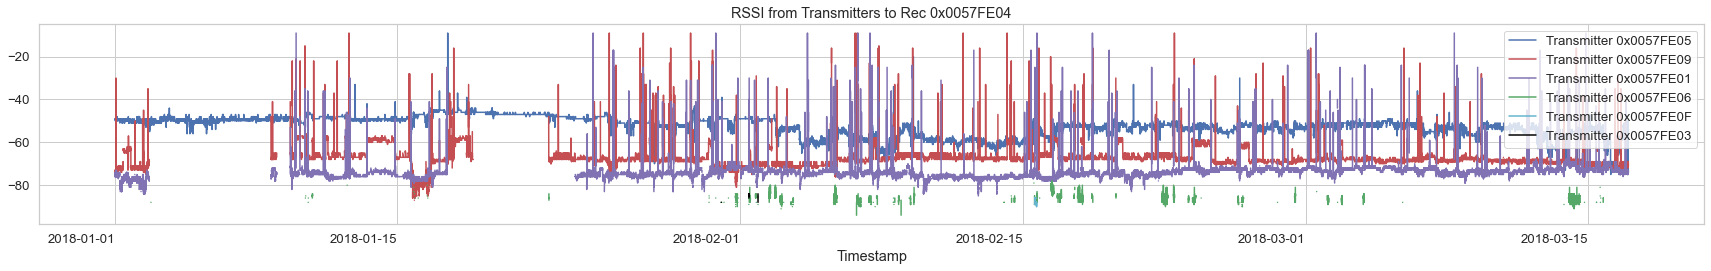

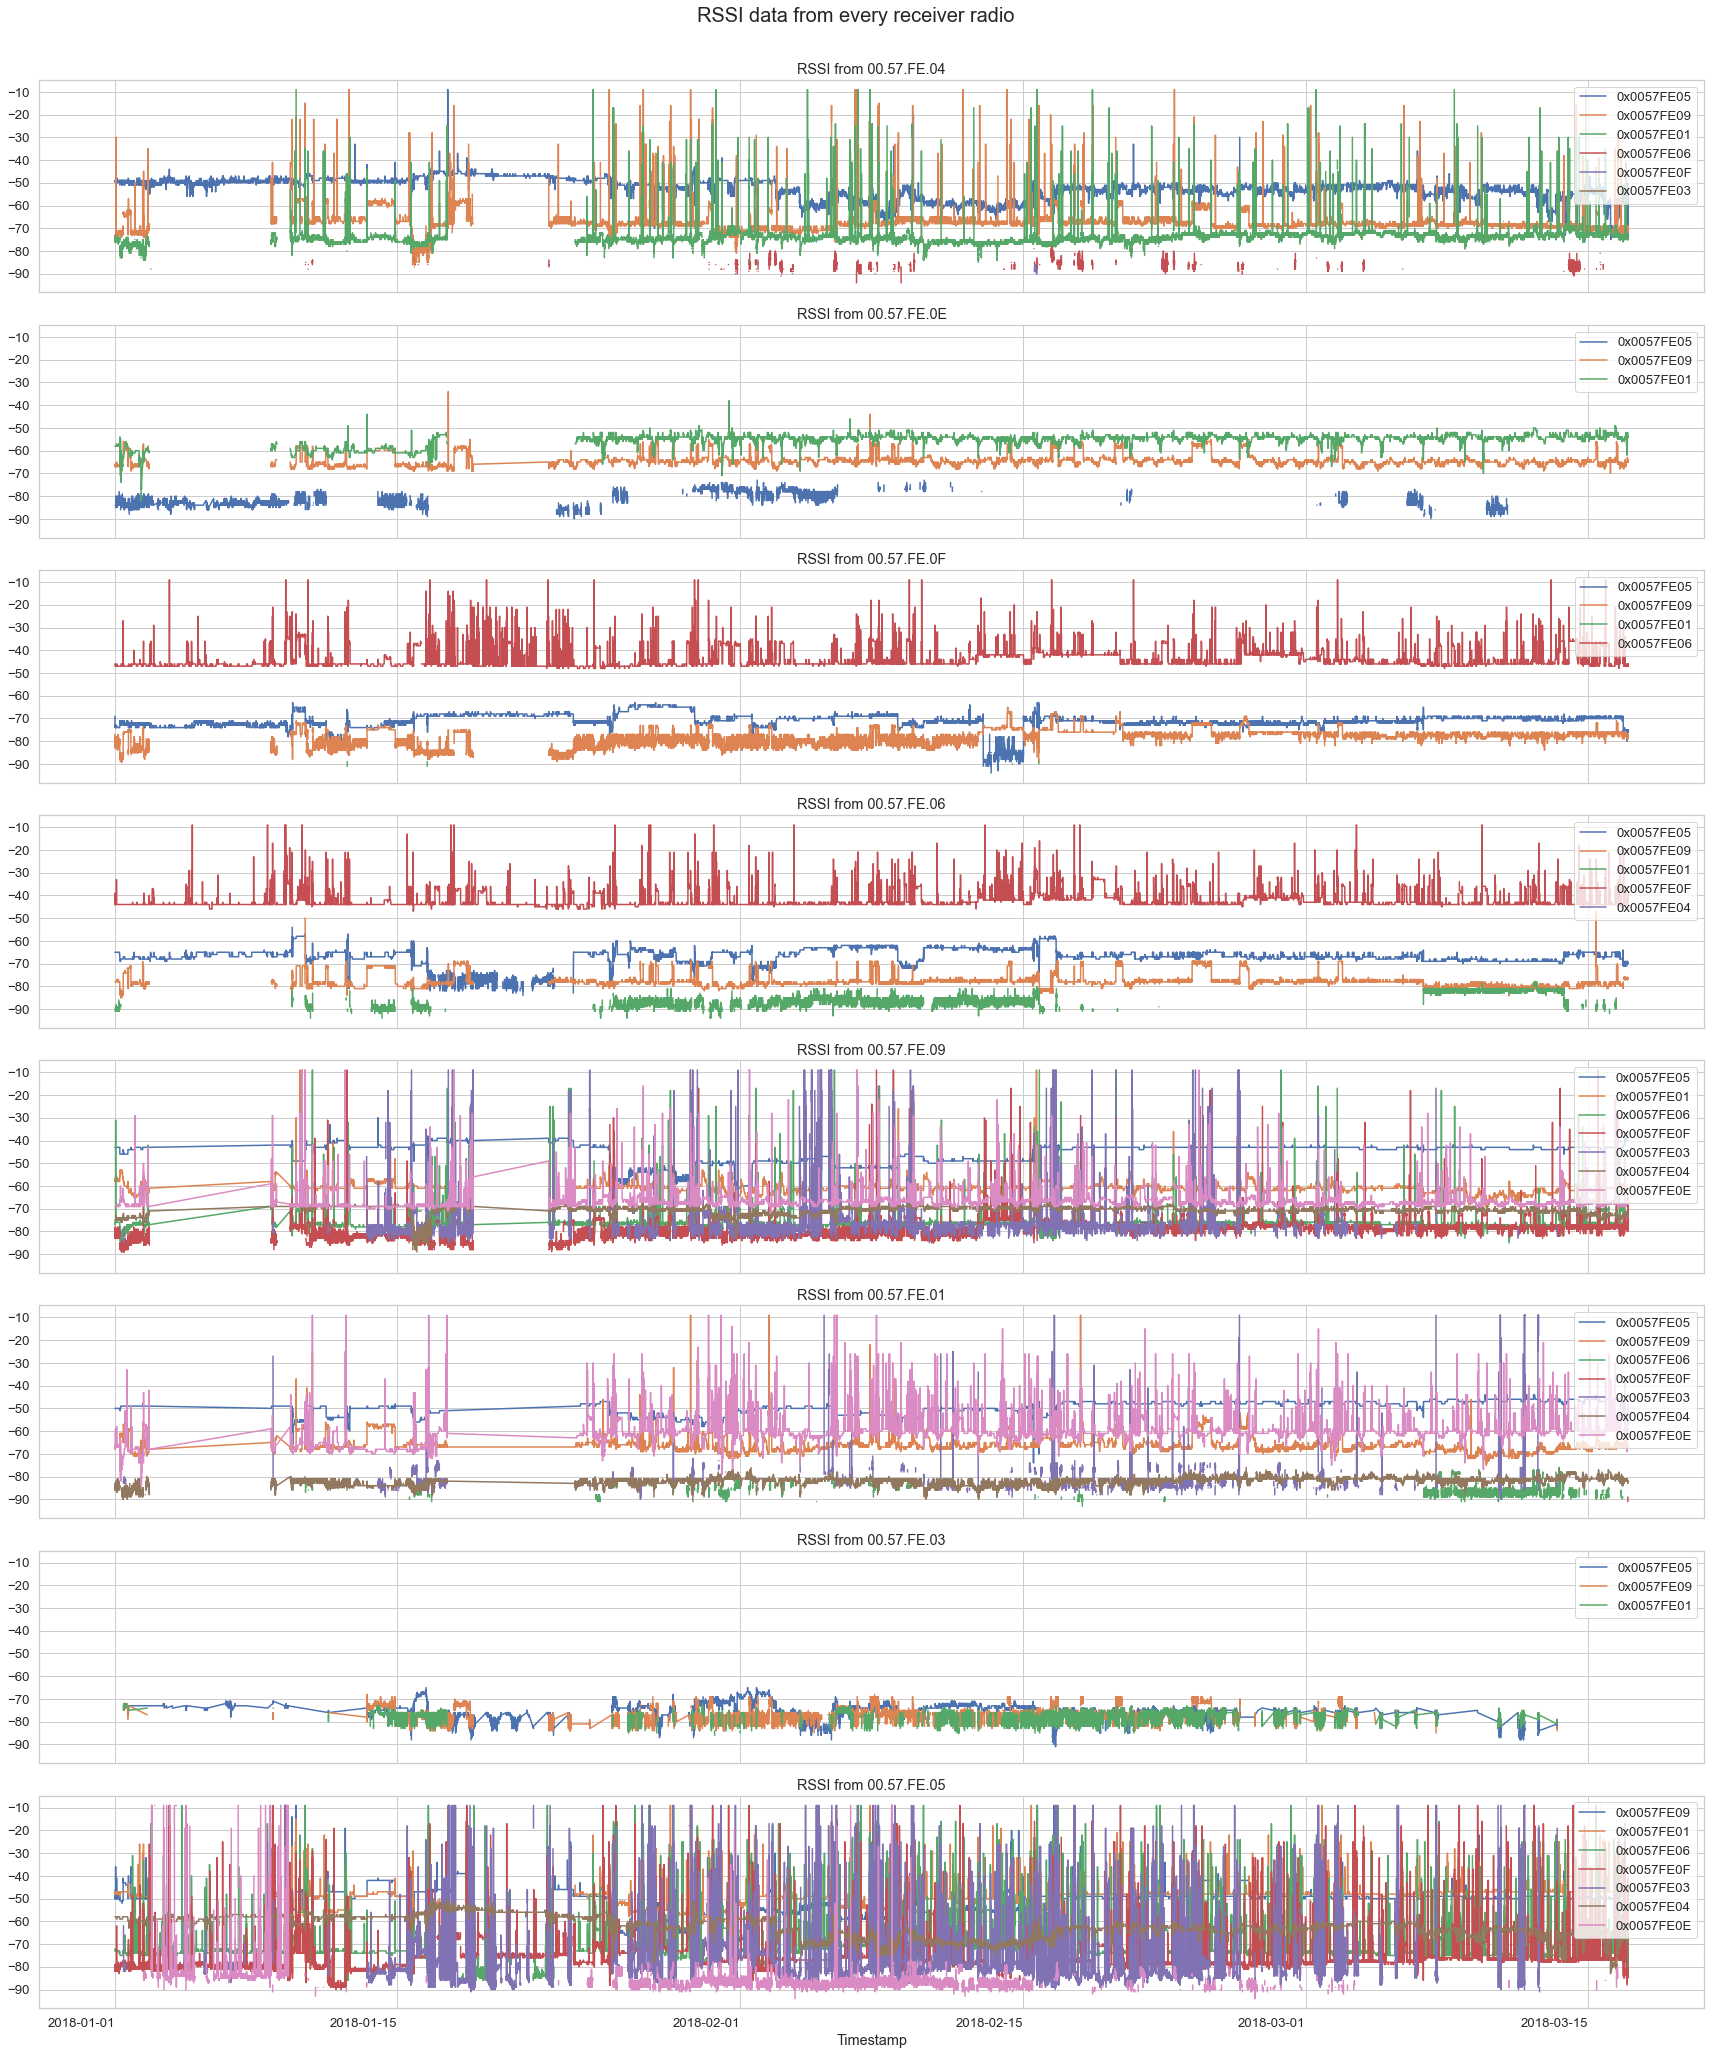

In [97]:
df_powers.set_index('Timestamp',drop=True, inplace=True)
start_date = '2018-01-01'
end_date='2018-03-16'
# This is for a single receiver and if it's needed to divide it into transmitters
# if plot_entire=True then plots the entire neighbour, as before, to show the problem stated above.
subset, serie, transmitters, Tx = arange_RSSI_serie(df_powers, receiver=0, start_date=start_date, end_date=end_date, joint=True, sharex=True, plot_entire=False)
dff = create_RSSI_dataframe(df_powers, df, plot=True, start_date=start_date, end_date=end_date, raw=True, resample_time=None)
#plt.figure(figsize=(24,5));sns.lineplot(data=dff[dff['Receiver']=='00.57.FE.03'].dropna(axis=1, how='all').drop('Receiver',axis=1))

We can see RSSI corresponding to every receiver in the specific time frame, there are menay spikes of -9 dbm present in almost every radio, the only radios that didn't presented spikes in this period of time were  00.57.FE.03 and radio 00.57.FE.0E, showing very stable RSSI values.<br>
It can be seen that RC (00.57.FE.04) receives data from 6 radios (00.57.FE.05; 00.57.FE.06; 00.57.FE.01; 00.57.FE.03; 00.57.FE.09 and 00.57.FE.0F) but the consistent ones are 05,09 and 01, the other 3 are very inconsistent. Transmitter 00.57.FE.05 transmit data in the entire period, the other 2 presented a gap in around january 22. If we continue inspecting this gap, we can see that is present in the rest of the receivers, so we could say that something happened around Januaty 18 that caused that some radios stopped transmission.<br>
Radios **00.57.FE.09, 00.57.FE.05 and 00.57.FE.01** receives from all radios and transmit to all. Thease are the most consisten ones. The Coordinator Radio RC don't present spikes and almost always presents a constant transmission level.

Let's take a look at the receivers data resampled in 60 Min. We can see the gap clearlier, many radios stop sending and receiving data around january 8 and 22. We can see that there is no evident trending or seasonality, we would have to explore that in a more deeper way.

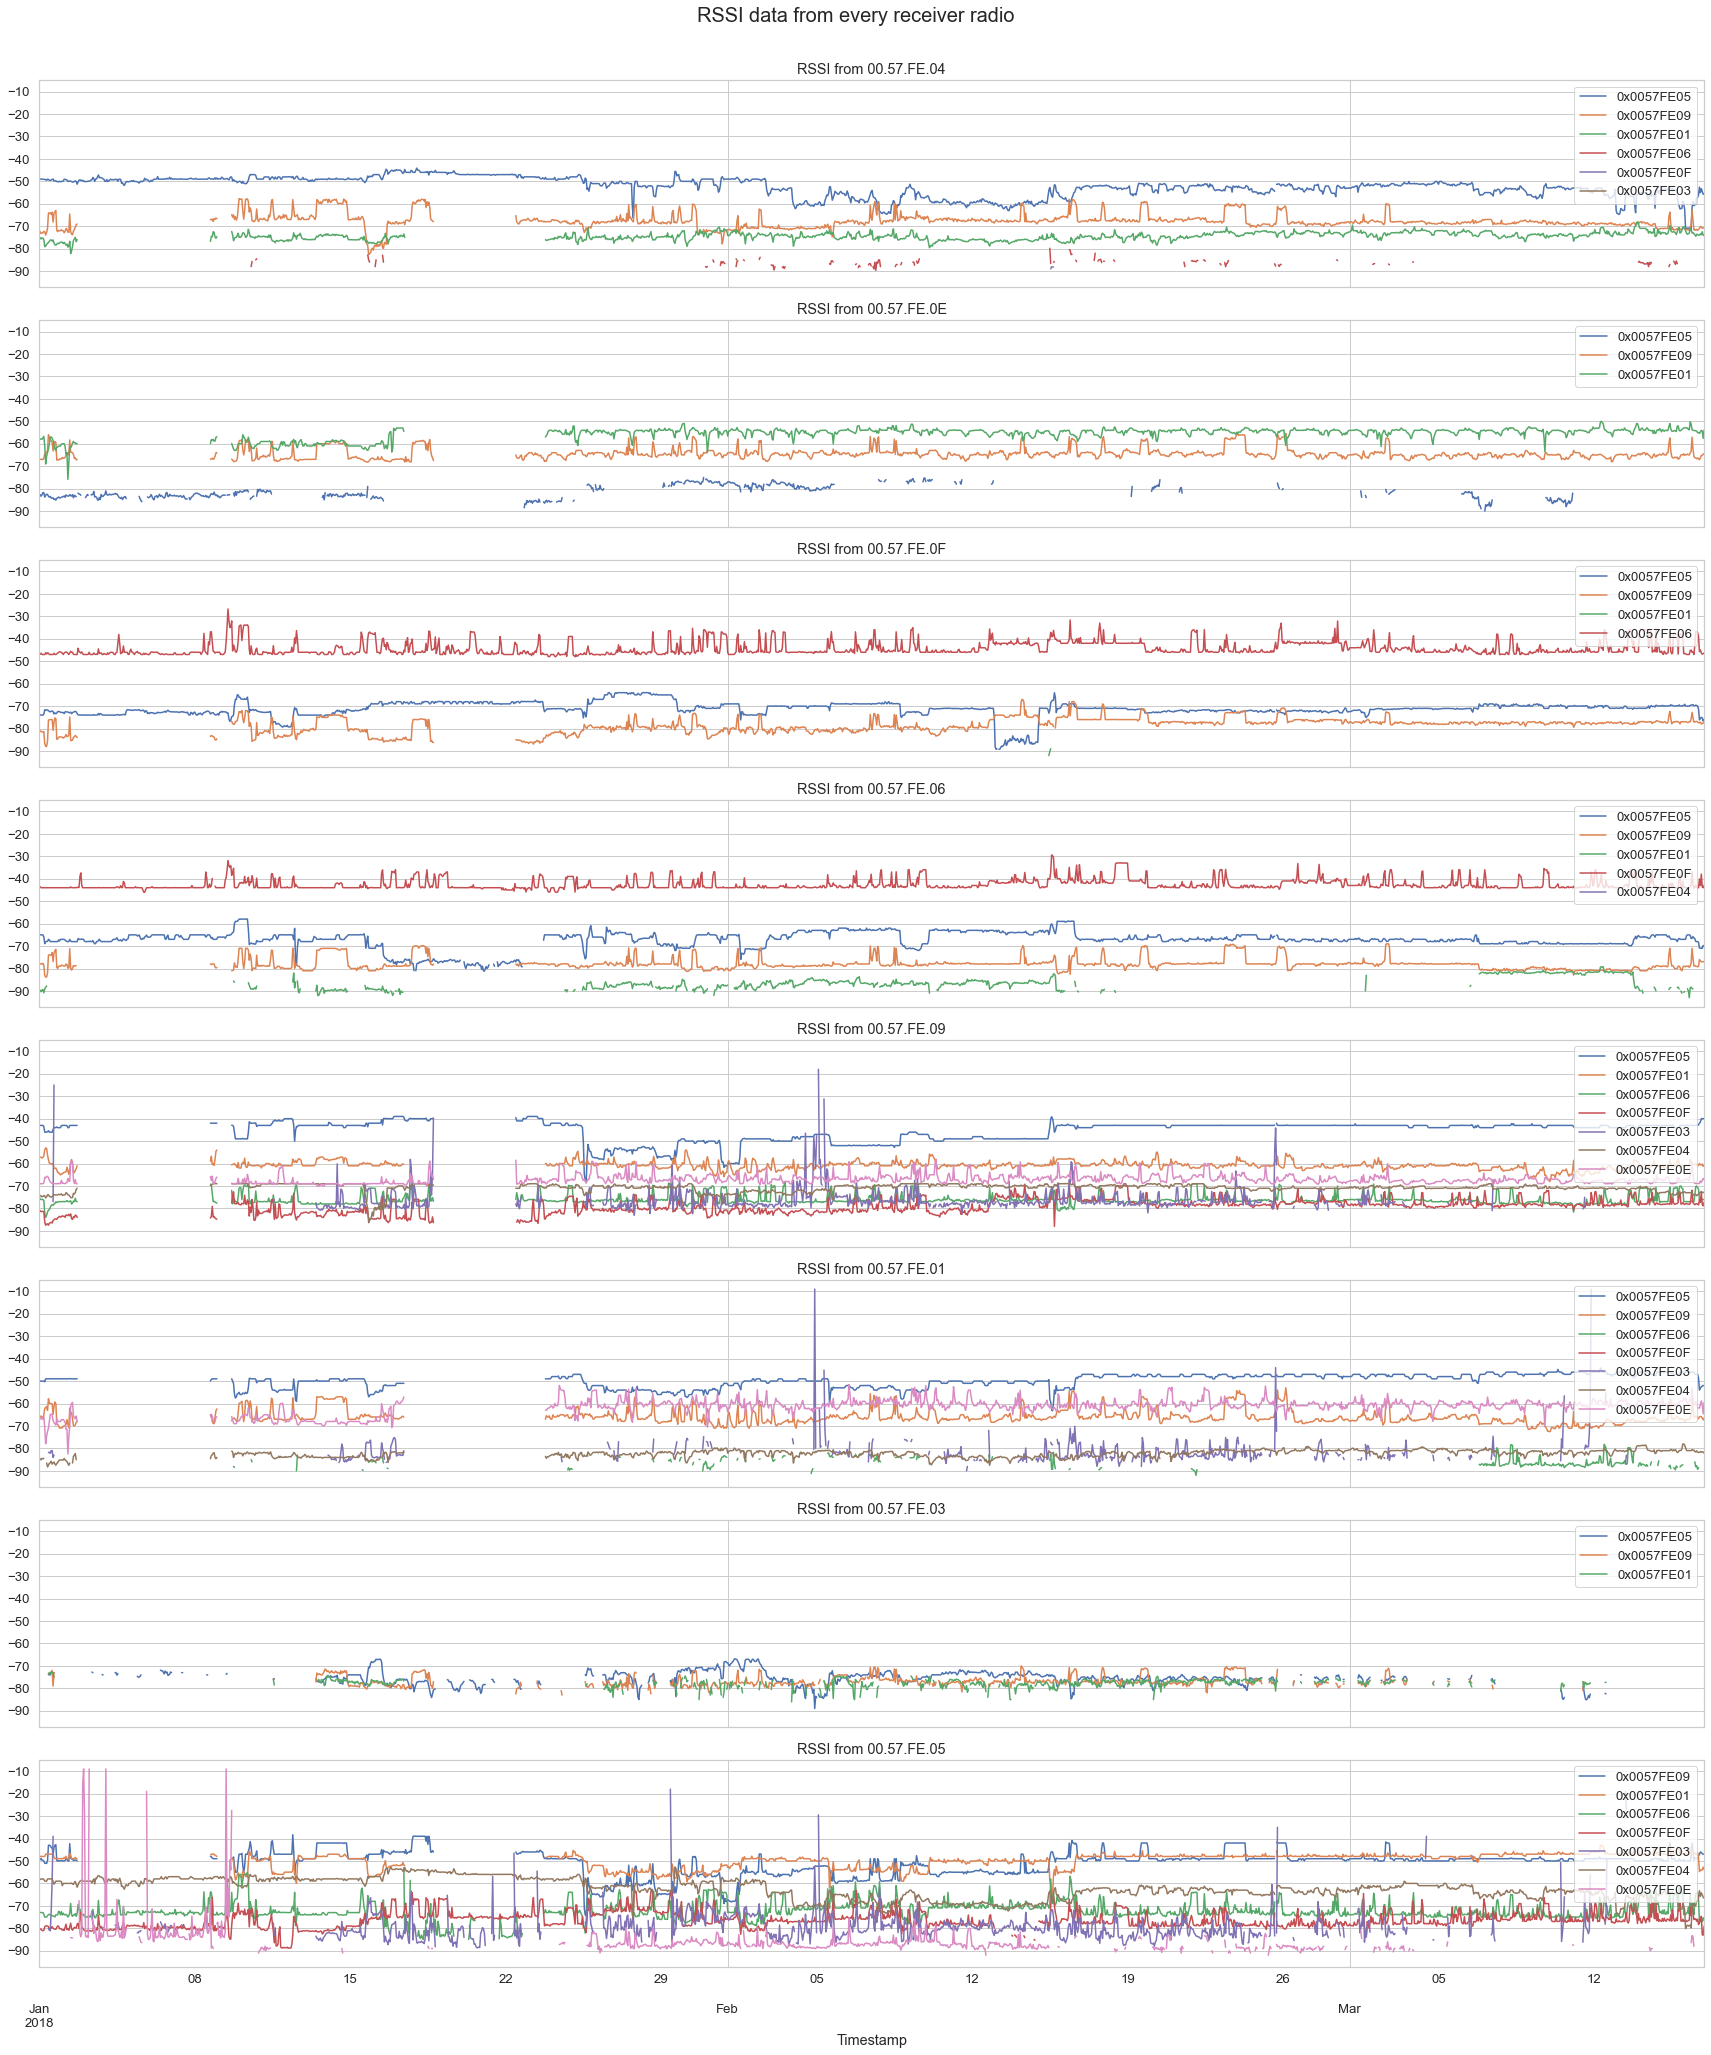

In [98]:
resample_time = '60Min'

color=['b','r','m','g','c','orange', 'y', 'grey']
fig, axes = plt.subplots(nrows=RECEIVERS.shape[0], ncols=1, figsize=(24,28), sharey=True, sharex=True)
fig.suptitle('RSSI data from every receiver radio', x=0.5, y=1.02, fontsize=20)
for ii, ax in zip(RADIOS, axes):
    dff[dff['Receiver']==ii].dropna(axis=1, how='all').resample(resample_time).mean().plot(ax=ax)
    ax.tick_params(labelrotation=0)
    ax.set_yticks(np.arange(-10, -100, step=-10))
    ax.set_title('RSSI from {}'.format(ii))
    ax.legend(loc='upper right')
plt.tight_layout()

In [99]:
dff = add_date_features(dff)
dff = dff[['Receiver','0x0057FE04', '0x0057FE0E','0x0057FE0F', '0x0057FE06',
           '0x0057FE09', '0x0057FE01', '0x0057FE03', '0x0057FE05', 'hour',
           'day','month','week','weekday','daylight']]
dff.head()

,Receiver,0x0057FE04,0x0057FE0E,0x0057FE0F,0x0057FE06,0x0057FE09,0x0057FE01,0x0057FE03,0x0057FE05,hour,day,month,week,weekday,daylight
Timestamp,,,,,,,,,,,,,,,
2018-01-01 00:00:19,00.57.FE.04,NaN,NaN,NaN,NaN,-74.0,-75.0,NaN,-49.0,0,1,1,1,0,0
2018-01-01 00:00:49,00.57.FE.04,NaN,NaN,NaN,NaN,-74.0,-76.0,NaN,-49.0,0,1,1,1,0,0
2018-01-01 00:01:19,00.57.FE.04,NaN,NaN,NaN,NaN,-74.0,-76.0,NaN,-49.0,0,1,1,1,0,0
2018-01-01 00:01:49,00.57.FE.04,NaN,NaN,NaN,NaN,-74.0,-76.0,NaN,-49.0,0,1,1,1,0,0
2018-01-01 00:02:19,00.57.FE.04,NaN,NaN,NaN,NaN,-74.0,-76.0,NaN,-49.0,0,1,1,1,0,0


### Amounth of data transmitted by neighbour

First is the amounth of data received by Radio. It can be seen that the one with more data is the Coordinator.<br>

Next is the amounth of data by transmitter in every neighbour. We can see how the quantities are lower as we increase in neighbour. Neighbour 1 presents the biggest amounth of data, almost all from module 0x0057FE05 to coordinator. The countplot of the Transmitters data by module only tells us that the biggest amounth of data is concentrated first 2 Transmitters. This is because every radio receives data from at least two modules, less radios from 3 modules and even less from all the modules. This is due to the Mesh Topology of the network.

Then let's check the amounth of data transmitted to every receiver and which radios intervine. As we can see, the biggest amounth of data is in neighbour 1 (TX1) and comes from module 05.

In the 3rd figure we can see a **Box Plot** of the RSSI in receiver by transmitter. We can conclude with this, for example, that transmitters 03, 06 and 0F are further from RC than the rest sice the RSSI mean is lower than the rest and close to -90 dbm. We can also see how modules 05, 09 and 01 are the most constant one since they send data to every other module.

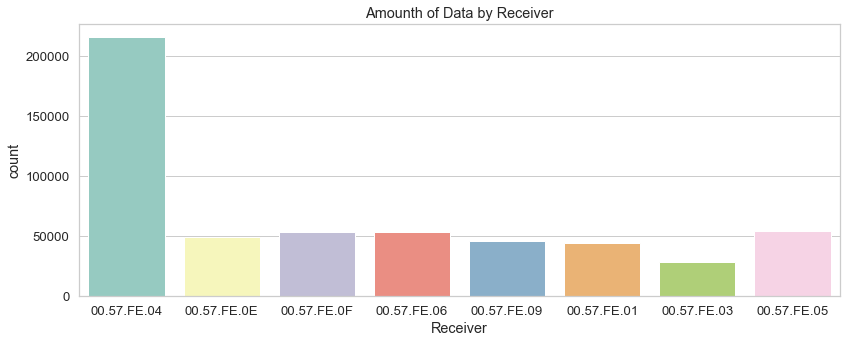

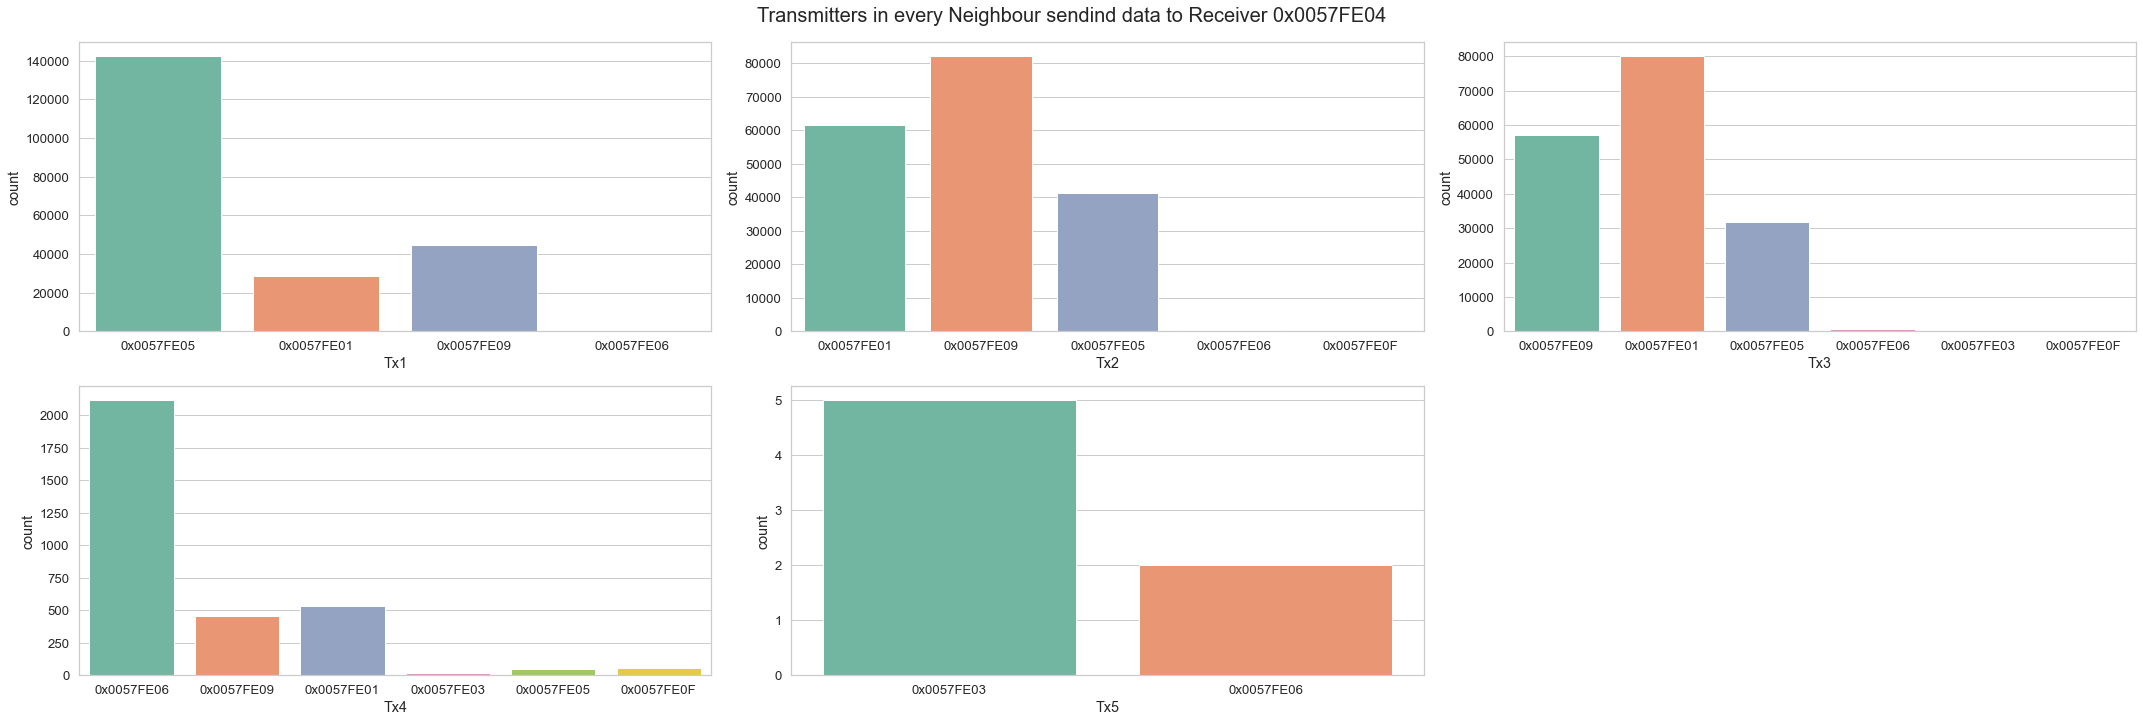

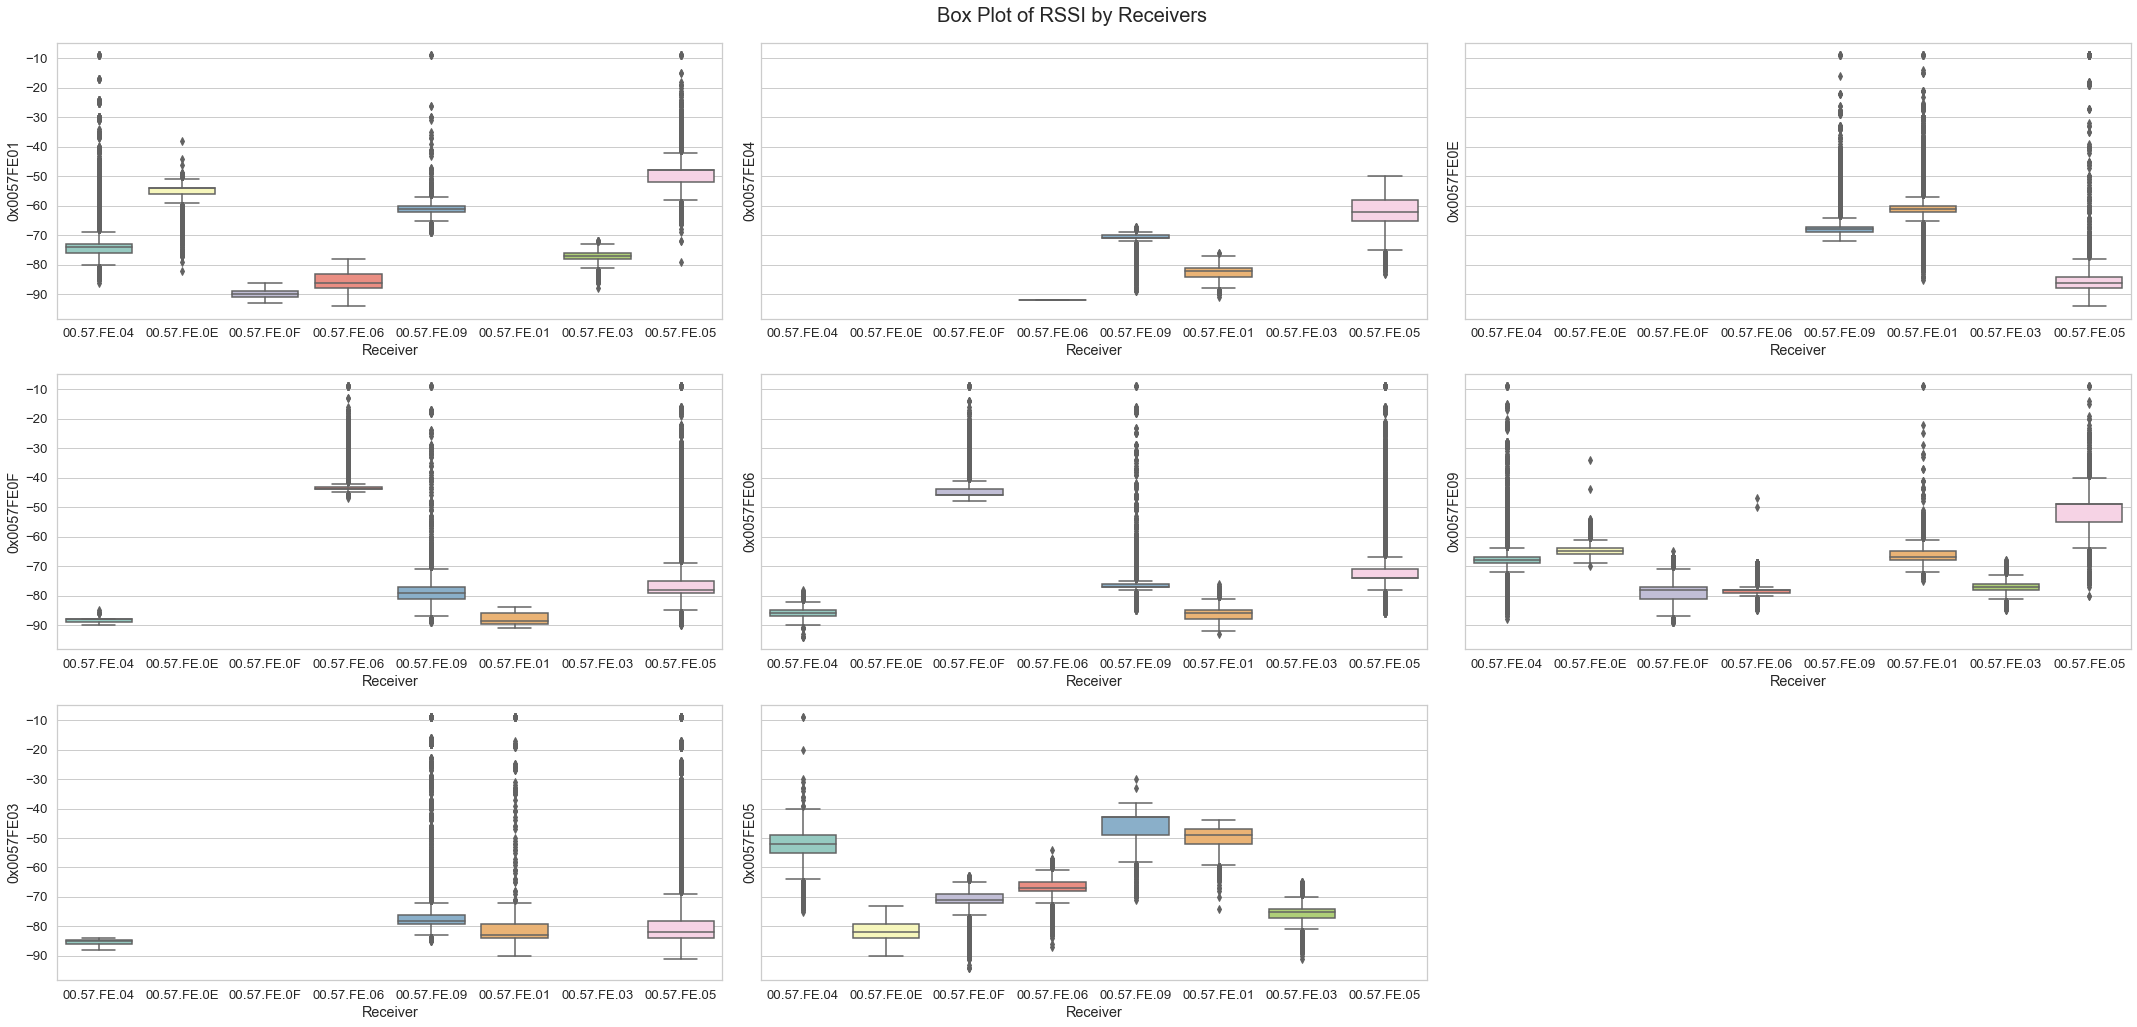

In [22]:
from rssi import plot_count_transmitters

plot_count_transmitters(dff, subset)

fig, axarr = plt.subplots(nrows=3, ncols=3, figsize=(30,14), sharey=True)
fig.delaxes(axarr[2,2])
plt.suptitle('Box Plot of RSSI by Receivers', x=0.5, y=1.02, fontsize=20)
sns.boxplot(x='Receiver',y=dff[dff.columns[6]],data=dff, ax=axarr[0,0], palette='Set3')
sns.boxplot(x='Receiver',y=dff[dff.columns[1]],data=dff, ax=axarr[0,1], palette='Set3')
sns.boxplot(x='Receiver',y=dff[dff.columns[2]],data=dff, ax=axarr[0,2], palette='Set3')
sns.boxplot(x='Receiver',y=dff[dff.columns[3]],data=dff, ax=axarr[1,0], palette='Set3')
sns.boxplot(x='Receiver',y=dff[dff.columns[4]],data=dff, ax=axarr[1,1], palette='Set3')
sns.boxplot(x='Receiver',y=dff[dff.columns[5]],data=dff, ax=axarr[1,2], palette='Set3')
sns.boxplot(x='Receiver',y=dff[dff.columns[7]],data=dff, ax=axarr[2,0], palette='Set3')
sns.boxplot(x='Receiver',y=dff[dff.columns[8]],data=dff, ax=axarr[2,1], palette='Set3')
plt.yticks(np.arange(-10, -100, step=-10))
plt.tight_layout()

Next we can see the distribution of the RSSI of transmitter to every receiver. By the distributions we can conclude what Radios are closer or further than the others and compare with the expected

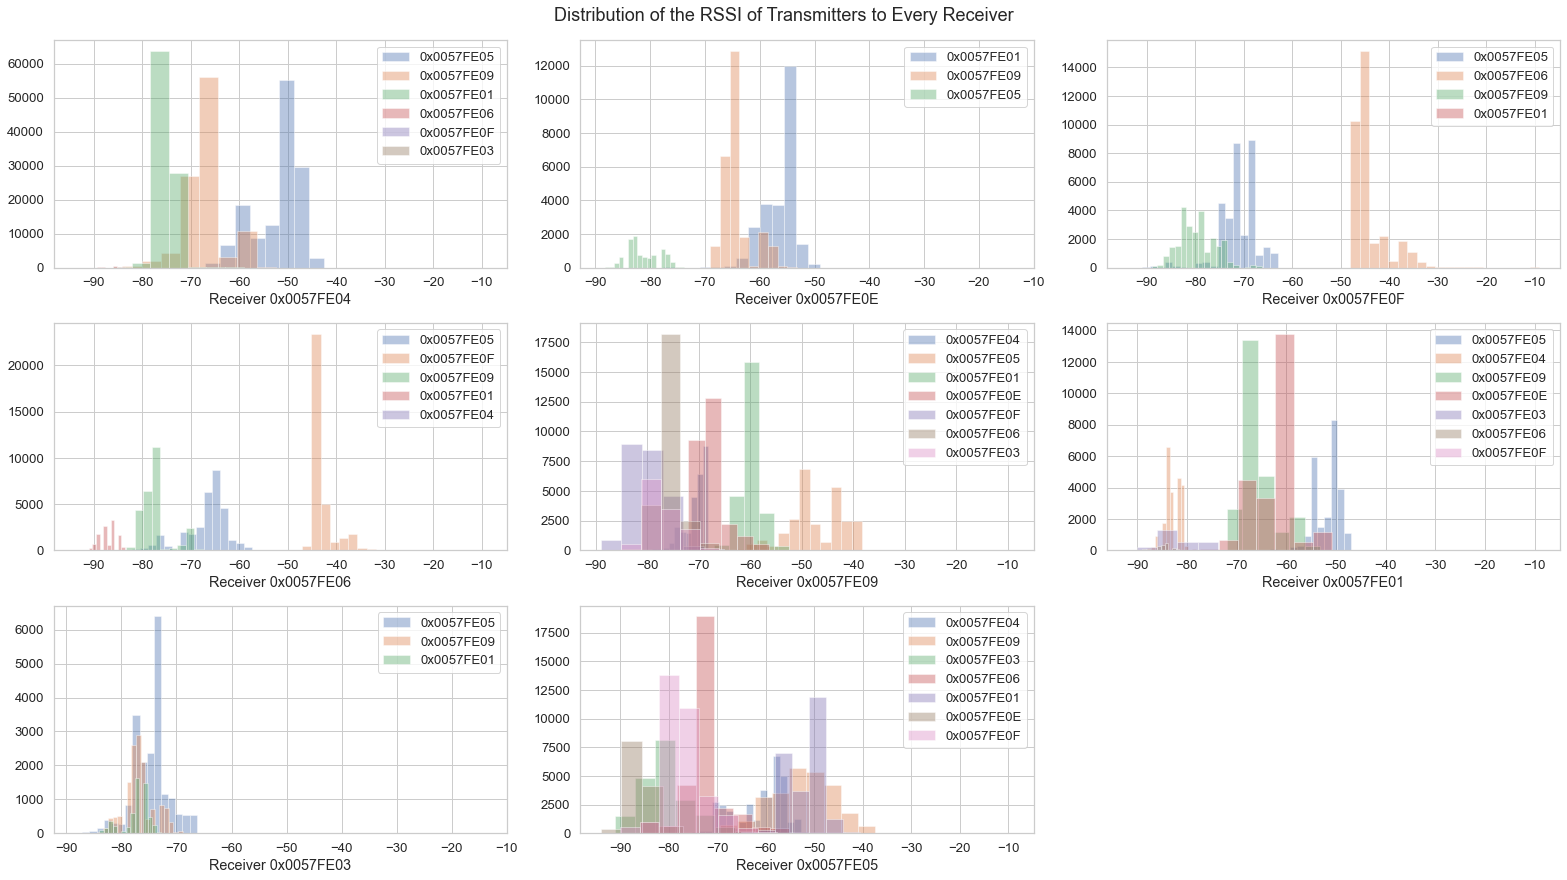

In [24]:
from rssi import dist_transmissions

fig, axes = plt.subplots(3,3, figsize=(22,12), sharex=False)
fig.suptitle('Distribution of the RSSI of Transmitters to Every Receiver', x=0.5, y=1.02, fontsize=18)
fig.delaxes(axes[2,2])
for rec, ax in zip(range(len(RECEIVERS)), axes.flat):
    dist_transmissions(df_powers, rec, RECEIVERS, ax)
    
# this is to create a boxplot by date of every receiver
#for ii in dff.columns[1:8]:
#    boxplot_PowerMod_date(dff, Tx=ii)
#    plt.tight_layout()
    
#plot_by_date(dff, by='day')

# Get correlation matrix
#correlation = dff.corr(method='pearson')
#fig, ax1 = plt.subplots(1,1, figsize=(18,12))
#ax1.set_title('Correlation Matrix for all RSSI data')
#sns.heatmap(correlation, annot=True, cmap='Set2',ax=ax1)
#plt.tight_layout()

# If needed the Reciprocal
#plot_reciprocal_RSSI(dff)

#### Move and Smoothe

In [100]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

Let's resample the data into 60 min frequency to see patterns

In [101]:
hourly_df = dff[dff['Receiver']=='00.57.FE.04'].resample('60Min').mean()
hourly_df = hourly_df.fillna(hourly_df.bfill())  # fill the missing data
hourly_df = hourly_df.dropna(axis=1, how='all')
hourly_df.head()

,0x0057FE0F,0x0057FE06,0x0057FE09,0x0057FE01,0x0057FE03,0x0057FE05,hour,day,month,week,weekday,daylight
Timestamp,,,,,,,,,,,,
2018-01-01 00:00:00,-89.0,-88.0,-73.7917,-75.2500,-88.0,-49.0083,0,1,1,1,0,0
2018-01-01 01:00:00,-89.0,-88.0,-72.4188,-75.0811,-88.0,-49.0083,1,1,1,1,0,0
2018-01-01 02:00:00,-89.0,-88.0,-73.1008,-75.6897,-88.0,-48.9583,2,1,1,1,0,0
2018-01-01 03:00:00,-89.0,-88.0,-73.0339,-75.2017,-88.0,-49.0167,3,1,1,1,0,0
2018-01-01 04:00:00,-89.0,-88.0,-72.9487,-75.3305,-88.0,-49.0083,4,1,1,1,0,0


Moving average can be used for smoothing of the time series to indicate trends. Pandas has an implementation available `DataFrame.rolling(window).mean()`. The wider the window - the smoother will be the trend. In the case of the very noisy data, which can be this case, this procedure can help to detect common patterns.

In [102]:
def plotMovingAverage(series, window=4, plot_intervals=False, scale=3, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 
        scale - can be modified to increase/decrease the boundries
    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(20,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=8)
        
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

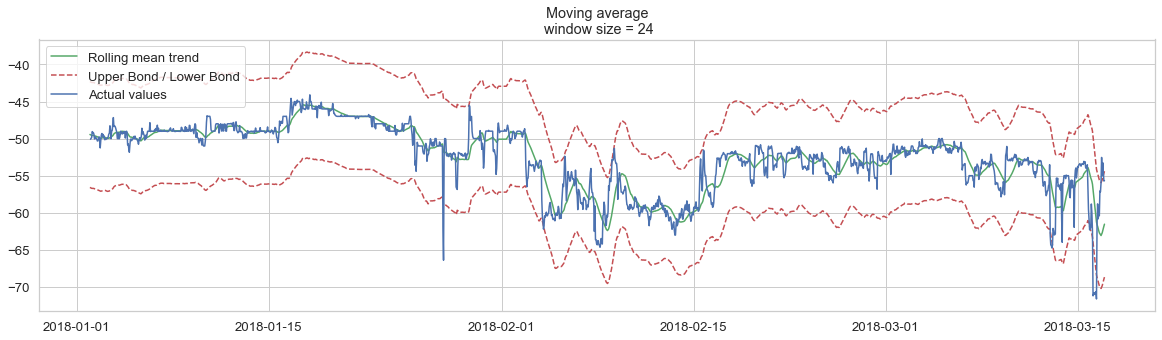

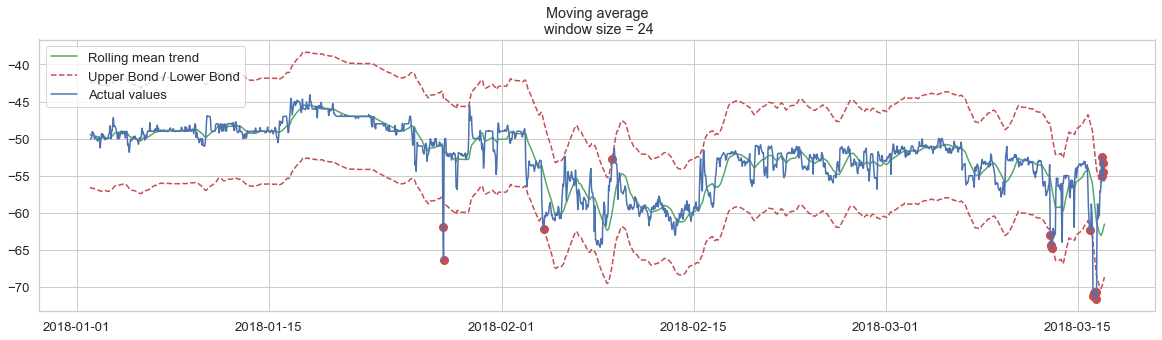

In [103]:
# Let's take a little zoom to see better the moving average
# smothing by 24 hours
serie = hourly_df[['0x0057FE05']]
#plotMovingAverage(serie, 12, plot_intervals=True) # Smothing by 12 hours
plotMovingAverage(serie, 24, plot_intervals=True) # Smothing by 24 hours
plotMovingAverage(serie[['0x0057FE05']], 24, plot_intervals=True, plot_anomalies=True) # Detecting anomalies

We can see the rolling mean and the boundries, also we catched some anomalies. Now, this are the values of one receiver only but we can do this for all.